In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



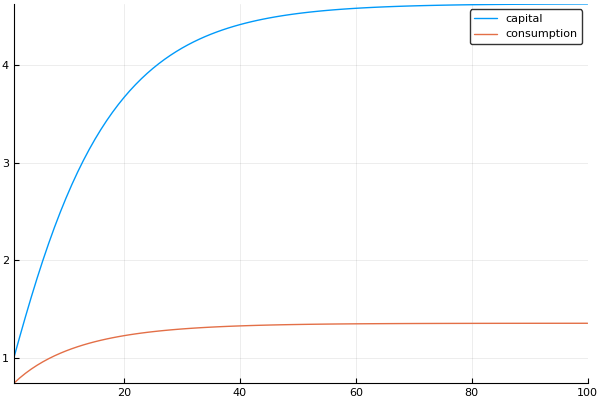

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [3]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [4]:
using JuMP
using Ipopt

m = Model(solver=IpoptSolver(print_level=5, max_iter=600));

I define the deep parameters variables and give the the correct starting values:

In [5]:
#@variable(m, 0 <= β <= 1, start = 0.95)
#@variable(m, 0 <= δ <= 1, start = 0.05)
#@variable(m, 0 <= α <= 1, start = 0.3)
#@variable(m, A >= 0, start = 1)
#@variable(m, γ >= 0, start = 2);

@variable(m, β == 0.95)
@variable(m, A == 1)
@variable(m, δ == 0.05)
@variable(m, α == 0.3)
@variable(m, γ == 2)

γ

The policy function is approximated by 10 Chebyshev polynomials on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

In [6]:
@variable(m, θ[1:10], start = 0)

#setvalue(θ[1], 0.1);

I define a grid on capital, $K$, with 10 nodes, and evaluate the Chebyshev polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [7]:
using BasisMatrices
basis = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1];

And I initialize $\theta$ such that the consumer myopically consumes almost everything available, leaving just $0.1$ capital for the next period:

In [8]:
initial_θ = Ψ \ (f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 1.)

for i in 1:10
    setvalue(θ[i], initial_θ[i])
end

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [9]:
function Ψprime(x, order)
    k_stst = 4.628988089138438
    a = 0.2*k_stst
    b = 2*k_stst
        
    z = (2/(b-a)) * (x-(a+b)/2)
    
    if (order == 1)
        return 1.
    elseif (order == 2)
        return z
    else
        
        out1 = 1.
        out2 = z
        out3 = 0.

        for j in 3:order
            out3 = 2. * z * out2 - out1
            out1 = out2
            out2 = out3
        end

        return out3
    end
end

Ψprime (generic function with 1 method)

I define auxiliary variables for model predictions of capital and consumption:

In [10]:
@variable(m, modelC[i=1:10], start = 1)
@variable(m, modelCprime[i=1:10], start = 1)
@variable(m, modelKprime[i=1:10], start = 1);

I register all user-defined functions with JuMP for automatic differentiation:

In [11]:
JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes:

In [12]:
@NLconstraint(m, cons_today[i=1:10], modelC[i] == sum(Ψ[i, k] * θ[k] for k in 1:10))
@NLconstraint(m, capi_tomor[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i]) 
@NLconstraint(m, cons_tomor[i=1:10], modelCprime[i] == sum(Ψprime(modelKprime[i], k) * θ[k] for k in 1:10))

@NLconstraint(m, EE[i=1:10], modelC[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));

In [13]:
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      280
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

:Optimal

In [42]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.95, 0.05, 0.3, 1.0, 2.0)


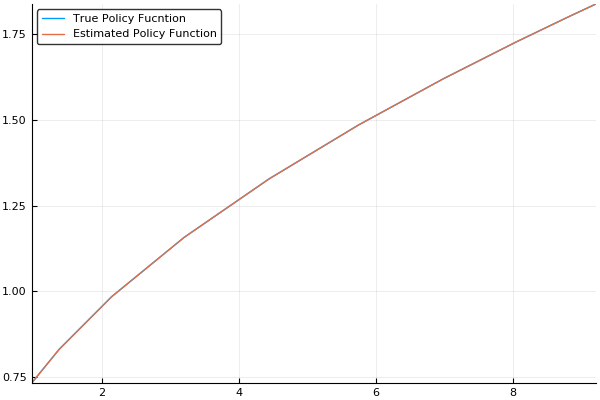

In [43]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, Ψ * getvalue(θ), label="Estimated Policy Function")

# Robustness in $\beta$
Varying the initial value for $\beta$ uncovers severe robustness issues:


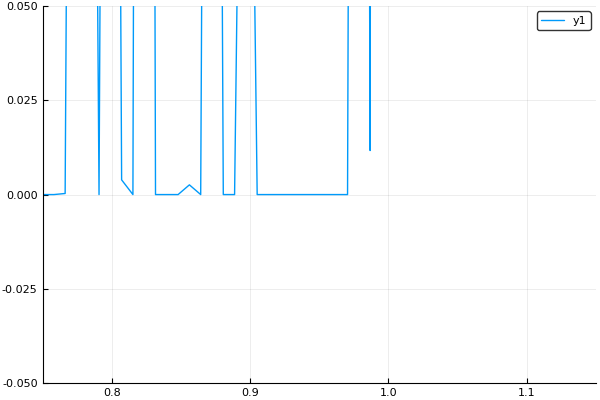

In [18]:
error = zeros(50)
initial_β = linspace(0.95-0.2, 0.95+0.2, 50)

for test in 1:50
    m = Model(solver=IpoptSolver(print_level=0, max_iter=600));
    
    @variable(m, 0 <= β <= 1, start = initial_β[test])
    @variable(m, 0 <= δ <= 1, start = 0.05) #rand(Normal(0.05, 0.1)))
    @variable(m, 0 <= α <= 1, start = 0.3) #rand(Normal(0.3, 0.1)))
    @variable(m, A >= 0, start = 1) #rand(Normal(1., 0.1)))
    @variable(m, γ >= 0, start = 2) #rand(Normal(2., 0.1)));
    @variable(m, θ[1:10], start = 0)
    
    initial_θ = Ψ \ (f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 0.1)

    for i in 1:10
        setvalue(θ[i], initial_θ[i])
    end
    
    @variable(m, modelC[i=1:10], start = 1)
    @variable(m, modelCprime[i=1:10], start = 1)
    @variable(m, modelKprime[i=1:10], start = 1);
        JuMP.register(m, :Ψprime, 2, Ψprime, autodiff=true)
    JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
    JuMP.register(m, :f, 3, f, autodiff=true)
    JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
    JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)
        @NLconstraint(m, cons_today[i=1:10], modelC[i] == sum(Ψ[i, k] * θ[k] for k in 1:10))
    @NLconstraint(m, capi_tomor[i=1:10], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i]) 
    @NLconstraint(m, cons_tomor[i=1:10], modelCprime[i] == sum(Ψprime(modelKprime[i], k) * θ[k] for k in 1:10))

    @NLconstraint(m, EE[i=1:10], modelC[i] == u_crra_prime_inv(
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ), γ));
    @NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
    @NLexpression(m, predictedC[t=1:100], sum(Φ[t, k] * θ[k] for k in 1:10));
    @NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))
    solve(m);
    error[test] = maximum(abs.([getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)] - [0.95, 0.05, 0.3, 1, 2]))
end

plot(initial_β, error, ylim=[-0.05,0.05])

The correct solution is not robustly found!